In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, clear_output

In [2]:
data = pd.read_csv('../data/fmnist_train.csv')
na_values = data.isna().sum().sum()
na_values

424

In [3]:
na_columns = data.isna().sum()
na_columns_with_values = na_columns[na_columns > 0]
na_columns_with_values

pixel361    1
pixel362    1
pixel363    1
pixel364    1
pixel365    1
           ..
pixel780    1
pixel781    1
pixel782    1
pixel783    1
pixel784    1
Length: 424, dtype: int64

In [4]:
data = data.fillna(0)

na_values_after_filling = data.isna().sum().sum()
na_values_after_filling

0

In [5]:
labels = data['label'].values
images = data.drop(columns=['label', 'Id']).values

images = images / 255.0
images = images.reshape(-1, 1, 28, 28)

labels_np = np.array(labels)
images_np = np.array(images)

X_train, X_val, y_train, y_val = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((13632, 1, 28, 28), (3408, 1, 28, 28), (13632,), (3408,))

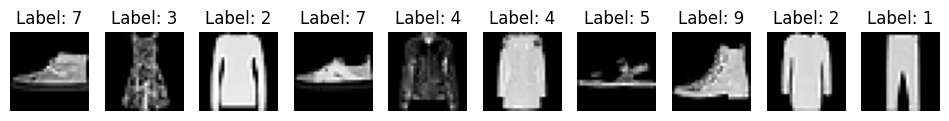

In [6]:
import matplotlib.pyplot as plt

def plot_images(images, labels, n=10):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, n=10)

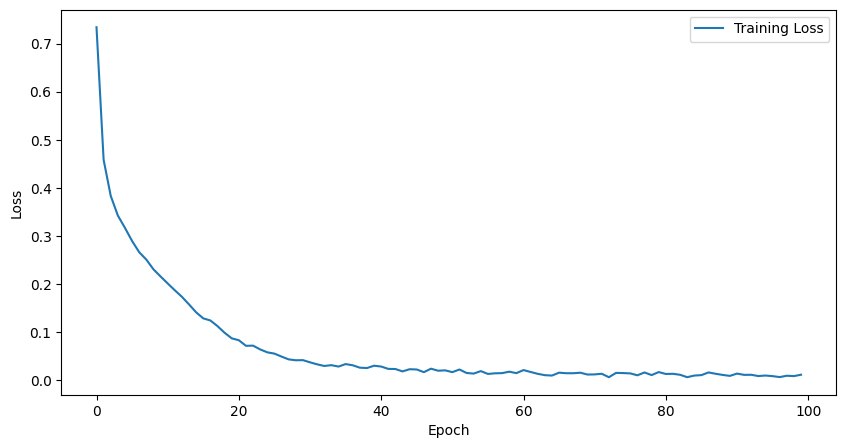

Validation Accuracy: 0.9085


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        display(plt.gcf())
        plt.close()

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

evaluate_model(model, val_loader, device)

In [8]:
save_path = 'trained_model_check.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)

print(f'Model and optimizer state have been saved to {save_path}')

Model and optimizer state have been saved to trained_model_check.pth


In [9]:
# Load test data
test_data = pd.read_csv('../data/fmnist_test.csv')

# Preprocess test data
test_ids = test_data['Id'].values
test_images = test_data.drop(columns=['Id']).values
test_images = test_images / 255.0
test_images = test_images.reshape(-1, 1, 28, 28)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

# Create test data loader
test_dataset = TensorDataset(test_images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Make predictions on test data
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({'Id': test_ids, 'Label': predictions})

# Assuming 'path_or_buf' is a string representing the file path
with open('submission.csv', 'w', newline='') as f:
  submission.to_csv(f, index=False)
